<a href="https://colab.research.google.com/github/farhadhsn8/implementation_ML_algorithms/blob/master/bagging_randomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
import random
import numpy as np
import math
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance
Iris = sns.load_dataset("iris")
import random
import statistics
from statistics import mode

In [2]:
class node:
  def __init__(self,name,features , targets , purityTreshold):
    self.nodeName = name
    self.purityTreshold = purityTreshold
    self.left = None
    self.right = None
    self.features = features
    self.targets = targets
    self.accuricy = self.computeAccuricy()
    self.label = None
    self.isTerminalNode = self.isTerminalNode()
    

  def computeAccuricy(self):
    if self.targets.shape[0]==0:
      return 1
    acc = np.bincount(self.targets.T.astype(int)).max() / self.targets.shape[0]
    return acc

  def isTerminalNode(self):
    if self.targets.shape[0]==0:
      return True
    if (self.accuricy >= self.purityTreshold ):
      self.label = np.bincount(self.targets.astype(int)).argmax()
      return True
    return False



  def findBestFeature(self):
    pass



    

  def findBestTresholdPlaceOnFeature(self, featureNumber):
    if self.targets.shape[0]==0:
      return 0
    FT = np.hstack((self.features[:,featureNumber].reshape((-1,1)),self.targets.reshape((-1,1))))
    max_acc = [0 , 0]
    for i in range(FT.shape[0]):
      smaller_filter = FT[:,0] <= FT[i,0]
      bigger_filter = FT[:,0] > FT[i,0]
      smaller_arr = FT[smaller_filter]
      bigger_arr = FT[bigger_filter] 
      L = np.bincount(smaller_arr[:,1].astype(int))[np.bincount(smaller_arr[:,1].astype(int)).argmax()]
      R =  np.bincount( np.hstack((bigger_arr[:,1].astype(int) ,  np.array([0]))))[np.bincount(    np.hstack((bigger_arr[:,1].astype(int), np.array([0]))    )).argmax()]
      correct = L + R
      acc = correct / FT.shape[0] 
      if acc > max_acc[1]:
        max_acc = [i,acc]
    return FT[max_acc[0] , 0]


  



class ID3(node):
  def __init__(self,name , features , targets , purityTreshold):
    super().__init__(name ,features , targets , purityTreshold)
    self.indexOfBestFeature = self.findBestFeature()
    self.treshold =  self.findBestTresholdPlaceOnFeature(self.indexOfBestFeature)
    childrens = self.computeChildrenData()
    self.Lfeatures = childrens[0][:,0:-1]
    self.Ltargets =  childrens[0][:,-1]
    self.Rfeatures = childrens[1][:,0:-1]
    self.Rtargets =   childrens[1][:,-1]
   


  def findBestFeature(self):
    info_I = self.computeInfo_I()
    max = [0,0]
    for i in range(self.features.shape[1]):
      tmp = self.computeInfo_I() - self.computeInfo_A(i)
      if (tmp >= max[1]):
        max = [i,tmp]
    return max[0]


  def computeInfo_I(self):
    I=0
    for i in np.bincount(self.targets.T.astype(int)):
      if i == 0 :
        I += 0
      else:
        A =  i / self.targets.shape[0]
        I+= -A*math.log2(A)
    return I


  def computeInfo_A(self , indexOfFeature):
    if self.targets.shape[0]==0:
      return 1
    treshold = self.findBestTresholdPlaceOnFeature(indexOfFeature)
    FT = np.hstack((self.features[:,indexOfFeature].reshape((-1,1)),self.targets.reshape((-1,1))))
    smaller_filter = FT[:,0] <= treshold
    bigger_filter = FT[:,0] > treshold
    smaller_arr = FT[smaller_filter]
    bigger_arr = FT[bigger_filter] 

    I_smaller = 0
    I_bigger = 0
    for i in range(np.bincount(self.targets.T.astype(int)).shape[0]):
      A = np.hstack(    (np.bincount(smaller_arr[:,1].astype(int)) , np.array([0,0,0,0,0]) )  )[i] / smaller_arr.shape[0]
      B = np.hstack(    (np.bincount(bigger_arr[:,1].astype(int)) , np.array([0,0,0,0,0]) )  )[i] / bigger_arr.shape[0]
      if A != 0 :
         I_smaller += -A*math.log2(A)
      if B != 0 :
         I_bigger +=  -B*math.log2(B)
    
    return (I_smaller * (smaller_arr.shape[0] / FT.shape[0]) )  +  (I_bigger * (bigger_arr.shape[0] / FT.shape[0]) )



  def computeChildrenData(self):
    FT = np.hstack((self.features,self.targets.reshape((-1,1))))

    smaller_filter = FT[:,self.indexOfBestFeature] <= self.treshold
    bigger_filter = FT[:,self.indexOfBestFeature] > self.treshold
    smaller_arr = FT[smaller_filter]
    bigger_arr = FT[bigger_filter]  
    return smaller_arr , bigger_arr





class C4_5(ID3):

  def findBestFeature(self):
    info_I = self.computeInfo_I()
    max = [0,0]
    for i in range(self.features.shape[1]):
      tmp = (self.computeInfo_I() - self.computeInfo_A(i)) / self.split_A(i)
      if (tmp >= max[1]):
        max = [i,tmp]
    return max[0]

  def split_A(self , indexOfFeature):
    if self.targets.shape[0]==0:
      return 1
    treshold = self.findBestTresholdPlaceOnFeature(indexOfFeature)
    FT = np.hstack((self.features[:,indexOfFeature].reshape((-1,1)),self.targets.reshape((-1,1))))
    smaller_filter = FT[:,0] <= treshold
    bigger_filter = FT[:,0] > treshold
    smaller_arr = FT[smaller_filter]
    bigger_arr = FT[bigger_filter] 
    A = smaller_arr.shape[0] / FT.shape[0]
    B = bigger_arr.shape[0] / FT.shape[0]
    Split_s = Split_b = 0
    if A != 0 :
      Split_s = -A*math.log2(A)
    if B != 0 :
      Split_b =  -B*math.log2(B)

    return Split_b + Split_s






    


class decisionTree:
  def __init__(self,features , targets , purityTreshold , method = 0): # method => 0:ID3  1:C4.5
    self.numberOfNodes = 0
    self.method = method
    if(method == 0 ):
      self.numberOfNodes += 1
      self.head = ID3(self.numberOfNodes,features , targets , purityTreshold)
    if(method == 1 ): 
      self.numberOfNodes += 1
      self.head = C4_5(self.numberOfNodes,features , targets , purityTreshold)
    self.developTree(self.head)

  def developTree(self , node):
    if(node.isTerminalNode == False):
      if( self.method == 0 ):
        self.numberOfNodes += 1
        node.left = ID3(self.numberOfNodes,node.Lfeatures , node.Ltargets , node.purityTreshold)
        self.numberOfNodes += 1
        node.right = ID3(self.numberOfNodes,node.Rfeatures , node.Rtargets , node.purityTreshold)
      if( self.method == 1 ):
        self.numberOfNodes += 1
        node.left = C4_5(self.numberOfNodes,node.Lfeatures , node.Ltargets , node.purityTreshold)
        self.numberOfNodes += 1
        node.right = C4_5(self.numberOfNodes,node.Rfeatures , node.Rtargets , node.purityTreshold) 
      self.developTree(node.left)
      self.developTree(node.right)

  def predict(self , Qdata , node  ):
    if(node.isTerminalNode):
      return node.label
    if (Qdata[node.indexOfBestFeature] < node.treshold):
      return self.predict(Qdata , node.left)
    return self.predict(Qdata , node.right)

  
  def showTree(self , node , layer_number = 0):
    print("layer  : ", layer_number , 'name : ', node.nodeName,'  indexOfBestFeature => ', node.indexOfBestFeature)
    layer_number+=1
    if(node.isTerminalNode == False):
      self.showTree( node.left ,layer_number )
      self.showTree( node.right ,layer_number )
    




class randomForest:
  def __init__(self,numberOfTrees,features , targets , purityTreshold , treeMethod = 0):
    self.trees = []
    self.numberOfTrees = numberOfTrees
    self.features = features
    self.targets = targets
    self.purityTreshold = purityTreshold
    self.treeMethod = treeMethod
    self.make_RandomForest()

  def bootstrapping(self):
    dataset = np.hstack(( self.features ,self.targets.reshape(-1,1)))
    A =  np.empty((0,dataset.shape[1]))
    for i in range(dataset.shape[0]):
      RV = random.randint(0 , dataset.shape[0]-1)
      A = np.append(A,np.array([dataset[RV,:]]), axis=0)
    return A




  def make_RandomForest(self):
    for i in range(self.numberOfTrees):
      dataset1 = self.bootstrapping()
      self.trees.append(decisionTree(dataset1[:,0:-1],dataset1[:,-1] , self.purityTreshold ,self.treeMethod ))

  def predict(self , Qdata):
    y_p = []
    for i in range(self.numberOfTrees):
      y_p.append(self.trees[i].predict(Qdata , self.trees[i].head))
    return max(set(y_p), key=y_p.count)

In [3]:
iris = datasets.load_iris()
features = iris.data  
target = iris.target
target1 = pd.get_dummies(iris.target).to_numpy()
dataset = np.hstack(( features ,target.reshape(-1,1)))
dataset.shape
#---------------shuffle---------------------
from sklearn.utils import shuffle
dataset=shuffle(dataset)
dataset.shape

#-------------test & train ---------------
train=dataset[0:120,:]    
test=dataset[120:,:]  
test.shape                #(30, 5)
train.shape              # (120, 5)

dataset[78]

array([6.3, 2.5, 5. , 1.9, 2. ])

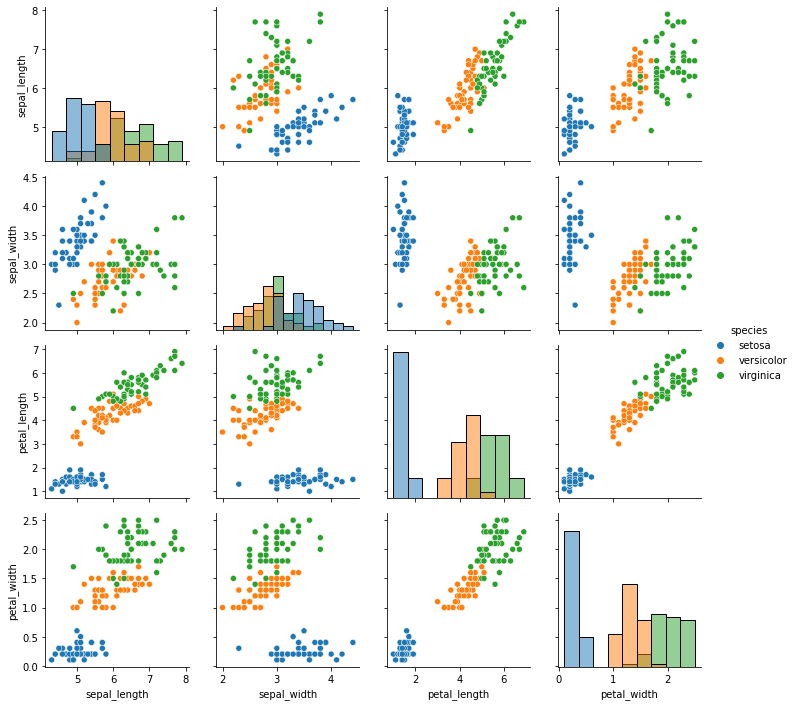

In [4]:
g = sns.PairGrid(Iris, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars


90.0 %  




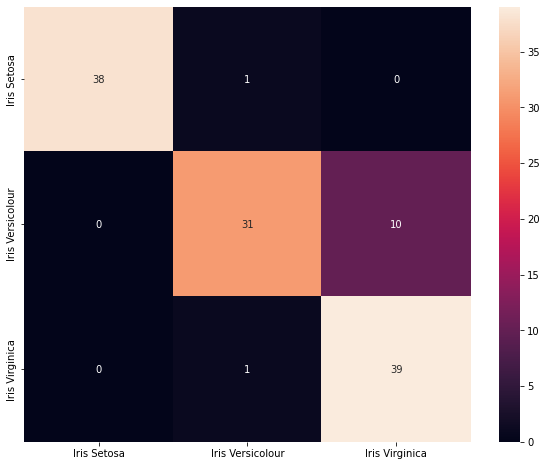

In [5]:
#--------acc on train data -------------------------
def cm_train(purity , wantCM=False ,method = 0):
  A = decisionTree(train[:,0:4],train[:,4] , purity ,method) 
  y_pred=[]
  for i in range(train.shape[0]):
    y_pred.append(A.predict(train[i,0:4],A.head))


  from sklearn.metrics import confusion_matrix
  y_true = train[:,4].T
  cm = confusion_matrix(y_true, y_pred)

  if wantCM :
    df_cm = pd.DataFrame(cm,['Iris Setosa','Iris Versicolour','Iris Virginica'],['Iris Setosa','Iris Versicolour','Iris Virginica'])
    plt.figure(figsize = (10,8))
    sns.heatmap(df_cm, annot=True)


  true = np.diag(cm)
  accuricy = np.sum(true)/np.sum(cm)
  return accuricy


print(str(cm_train(0.8, True , 1 ) * 100 )+' % ' , '\n\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars


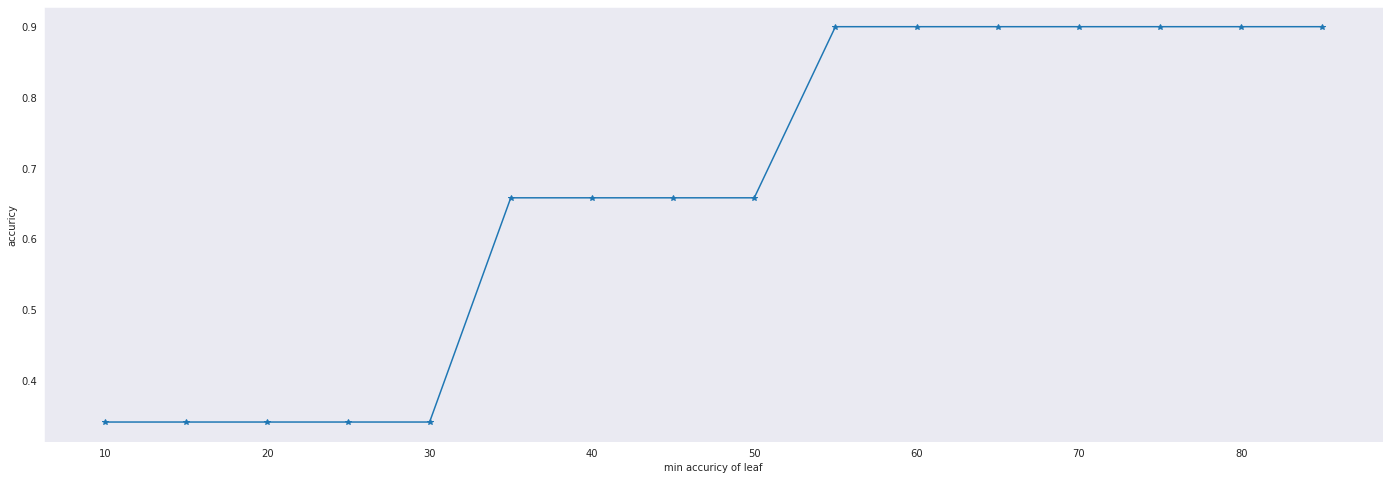

In [6]:
accs = []
for i in range(10,90,5):
  accs.append(cm_train(i/100 ,False , 1))
sns.set_style("darkgrid")
plt.figure(figsize = (24,8))
plt.plot(range(10,90,5), accs , marker = '*')
plt.xlabel("min accuricy of leaf")
plt.ylabel("accuricy")
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars


96.66666666666667 %  




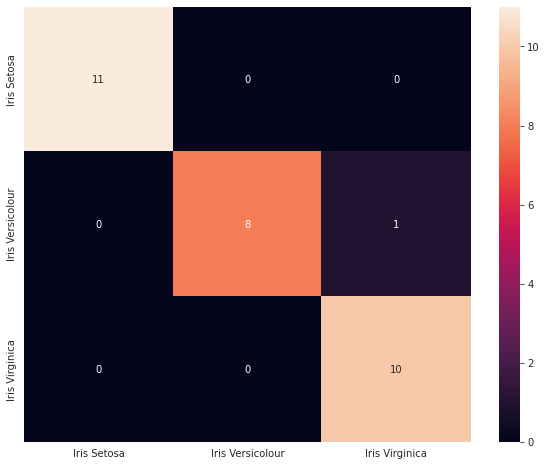

In [7]:
#----------------test data------------------
def cm_test(purity , wantCM=False , method = 0):
  A = decisionTree(train[:,0:4],train[:,4] , purity ,method) 
  y_pred=[]
  for i in range(test.shape[0]):
    y_pred.append(A.predict(test[i,0:4],A.head))


  from sklearn.metrics import confusion_matrix
  y_true = test[:,4].T
  cm = confusion_matrix(y_true, y_pred)

  if wantCM :
    df_cm = pd.DataFrame(cm,['Iris Setosa','Iris Versicolour','Iris Virginica'],['Iris Setosa','Iris Versicolour','Iris Virginica'])
    plt.figure(figsize = (10,8))
    sns.heatmap(df_cm, annot=True)


  true = np.diag(cm)
  accuricy = np.sum(true)/np.sum(cm)
  return accuricy


print(str(cm_test(0.8, True , 0 ) * 100 )+' % ' , '\n\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars


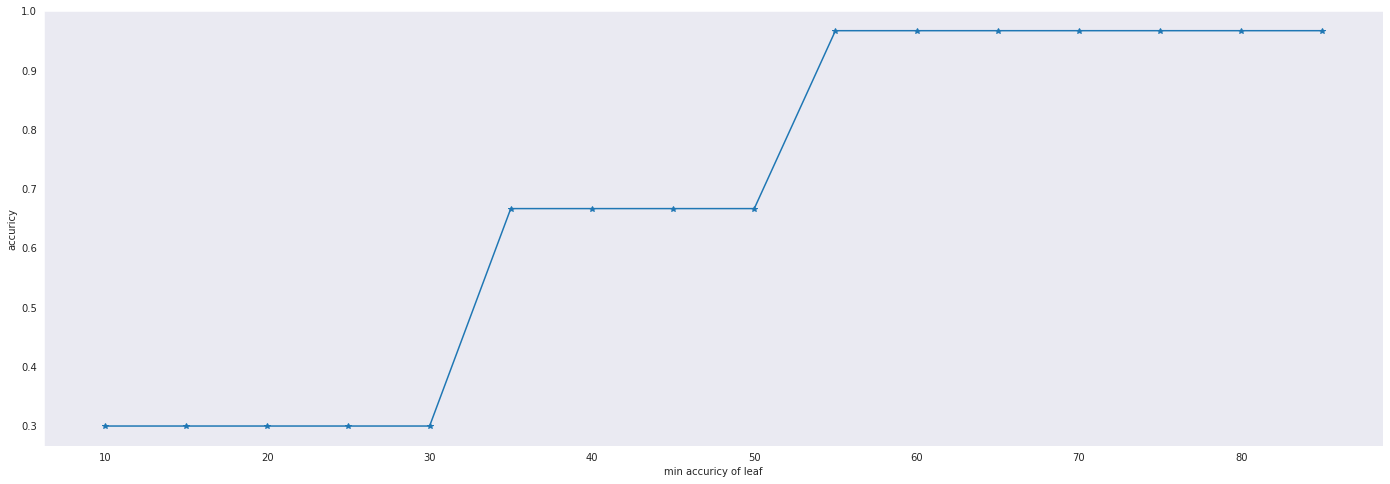

In [8]:
#------------test Data - -----------------

accs = []
for i in range(10,90,5):
  accs.append(cm_test(i/100))
sns.set_style("darkgrid")
plt.figure(figsize = (24,8))
plt.plot(range(10,90,5), accs , marker = '*')
plt.xlabel("min accuricy of leaf")
plt.ylabel("accuricy")
plt.grid()
plt.show()

In [9]:
A = decisionTree(train[:,0:4],train[:,4] , 0.8 ,0) 
A.showTree(A.head)

layer  :  0 name :  1   indexOfBestFeature =>  3
layer  :  1 name :  2   indexOfBestFeature =>  3
layer  :  1 name :  3   indexOfBestFeature =>  2
layer  :  2 name :  4   indexOfBestFeature =>  3
layer  :  2 name :  5   indexOfBestFeature =>  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars


In [10]:
B = randomForest(10 , train[:,0:4],train[:,4] , 0.6 ,0)
B.predict([6.7, 3.3, 5.7, 2.1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars


2

93.33333333333333 %  




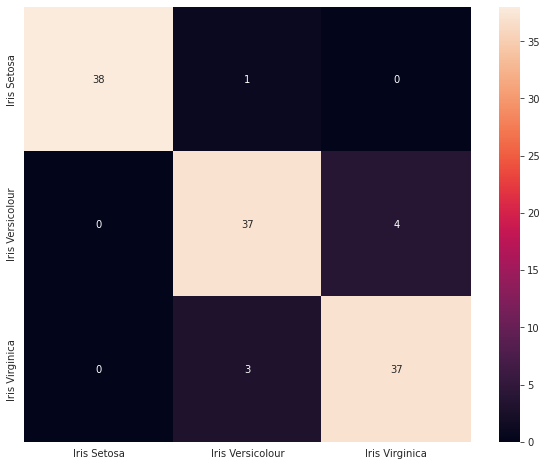

In [11]:
#--------acc on train data RANDOM_FOREST-------------------------
y_pred=[]
for i in range(train.shape[0]):
  y_pred.append(B.predict(train[i,0:4]))


from sklearn.metrics import confusion_matrix
y_true = train[:,4].T
cm = confusion_matrix(y_true, y_pred)


df_cm = pd.DataFrame(cm,['Iris Setosa','Iris Versicolour','Iris Virginica'],['Iris Setosa','Iris Versicolour','Iris Virginica'])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True)


true = np.diag(cm)
accuricy = np.sum(true)/np.sum(cm)
print(str(accuricy * 100)+' % ' , '\n\n')

100.0 %  




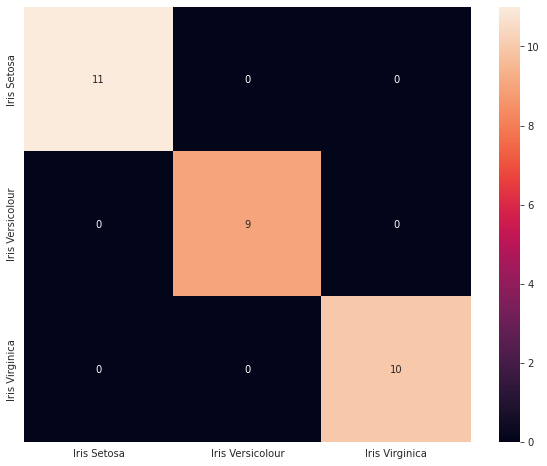

In [12]:
#----------------test data  RANDOM_FOREST------------------
y_pred=[]
for i in range(test.shape[0]):
  y_pred.append(B.predict(test[i,0:4]))


from sklearn.metrics import confusion_matrix
y_true = test[:,4].T
cm = confusion_matrix(y_true, y_pred)


df_cm = pd.DataFrame(cm,['Iris Setosa','Iris Versicolour','Iris Virginica'],['Iris Setosa','Iris Versicolour','Iris Virginica'])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True)

true = np.diag(cm)
accuricy = np.sum(true)/np.sum(cm)
print(str(accuricy * 100)+' % ' , '\n\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars


100.0 %  




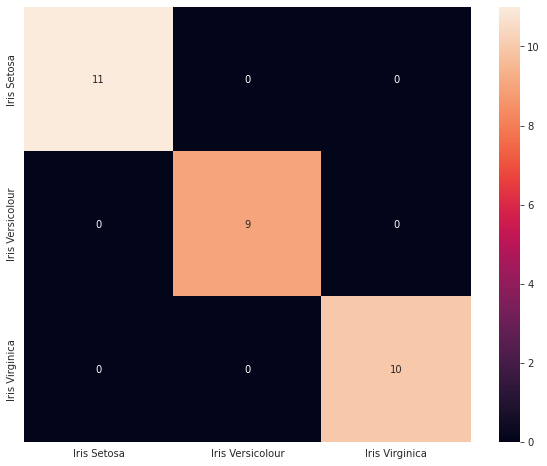

In [13]:
def cm_test_RF( numOfTrees,purity , wantCM=False , method = 0):
  B1 = randomForest(numOfTrees , train[:,0:4],train[:,4] , purity,method)
  
  y_pred=[]
  for i in range(test.shape[0]):
    y_pred.append(B1.predict(test[i,0:4]))


  from sklearn.metrics import confusion_matrix
  y_true = test[:,4].T
  cm = confusion_matrix(y_true, y_pred)

  if wantCM :
    df_cm = pd.DataFrame(cm,['Iris Setosa','Iris Versicolour','Iris Virginica'],['Iris Setosa','Iris Versicolour','Iris Virginica'])
    plt.figure(figsize = (10,8))
    sns.heatmap(df_cm, annot=True)


  true = np.diag(cm)
  accuricy = np.sum(true)/np.sum(cm)
  return accuricy


print(str(cm_test_RF(10,0.75, True , 0 ) * 100 )+' % ' , '\n\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in long_scalars
/usr/loc

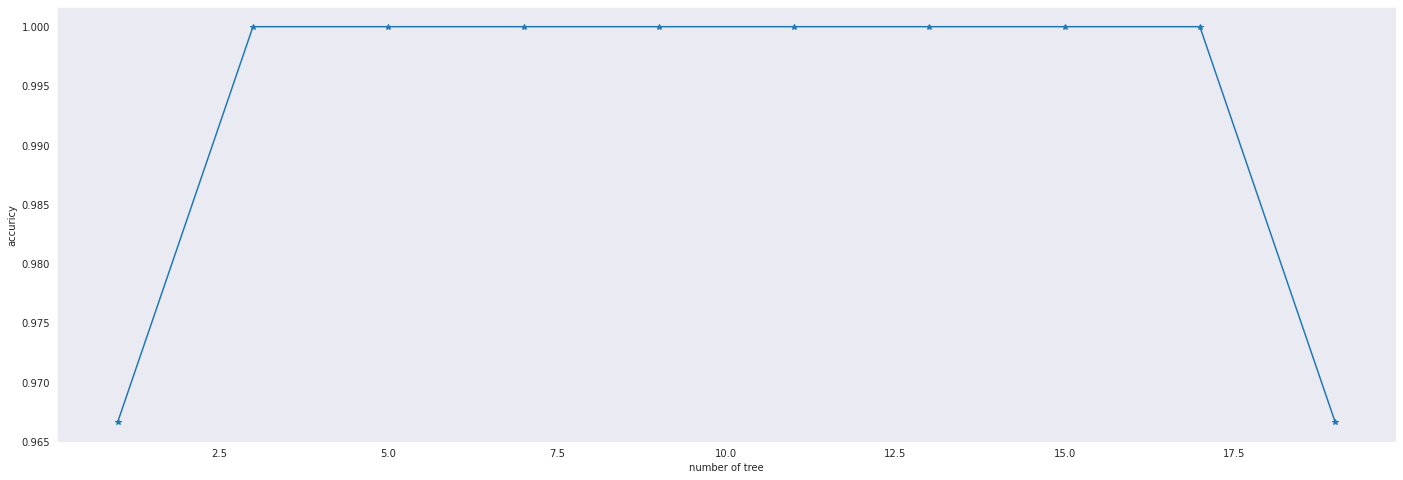

In [14]:
accs = []
for i in range(1,20,2):
  accs.append(cm_test_RF(i , 0.75 , False , 0))
sns.set_style("darkgrid")
plt.figure(figsize = (24,8))
plt.plot(range(1,20,2), accs , marker = '*')
plt.xlabel("number of tree")
plt.ylabel("accuricy")
plt.grid()
plt.show()